In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

In [2]:
# Load Calibration Images
cal_images = glob.glob('./camera_cal/calibration*')

In [3]:
# Chessboard size of 9 x 6
nx = 9
ny = 6
chess_size = (nx, ny)

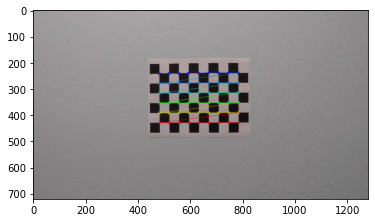

In [4]:
# Try with one calibration image

one_example = cv2.imread(cal_images[2])
gray = cv2.cvtColor(one_example, cv2.COLOR_BGR2GRAY)

ret, corners = cv2.findChessboardCorners(gray, chess_size, None)

if ret == True:
    cv2.drawChessboardCorners(one_example, chess_size, corners, ret)
    plt.imshow(one_example)

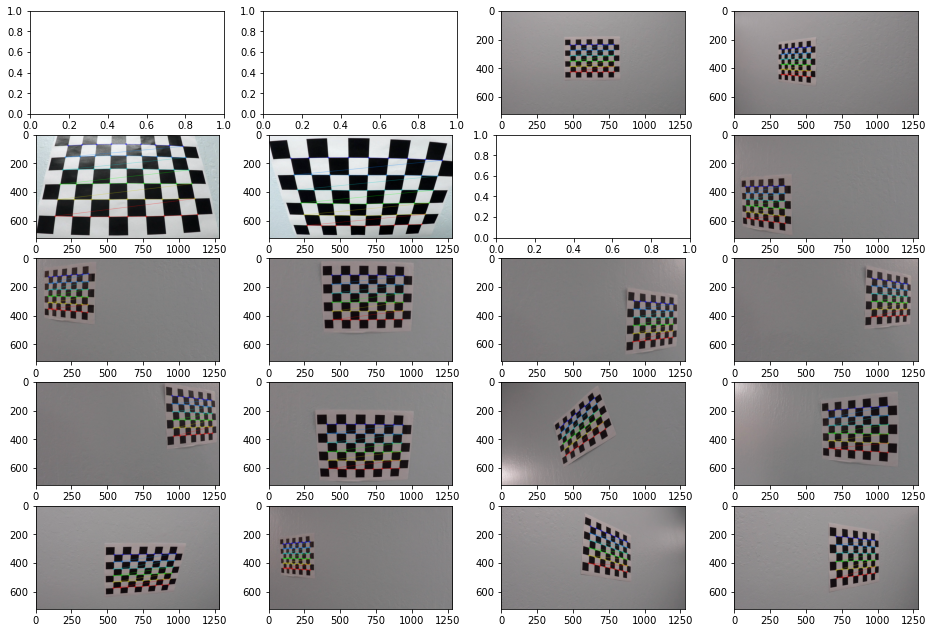

In [5]:
# Run for all images
fig, axs = plt.subplots(5,4, figsize=(16, 11))
axs = axs.ravel()

objpoints = []
imgpoints = []

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

for i, image in enumerate(cal_images):
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, chess_size, None)

    if ret == True:
        objpoints.append(objp)
        corners2 = cv2.cornerSubPix(gray,corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners)

        img = cv2.drawChessboardCorners(img, chess_size, corners, ret)
        plt.imshow(img)
        axs[i].imshow(img)

Text(0.5, 1.0, 'Undistorted')

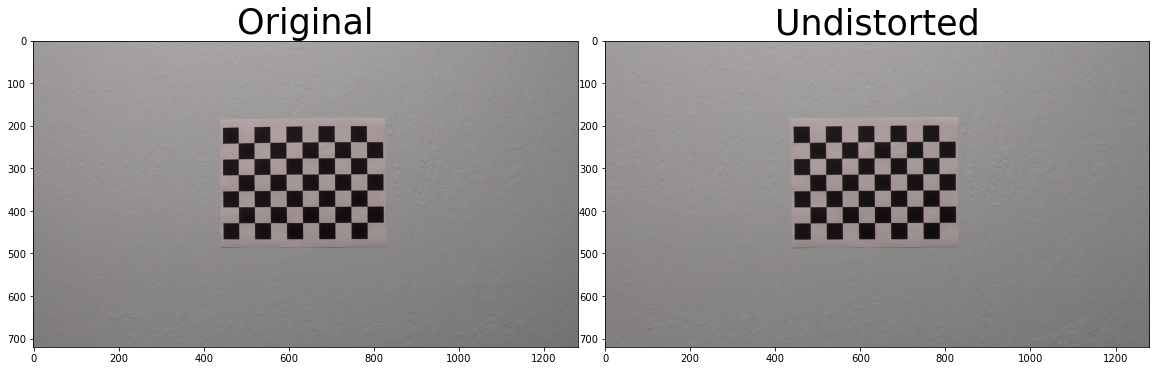

In [6]:
# Calibrate one image
img = cv2.imread(cal_images[2])
img_size = (img.shape[0], img.shape[1])

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

undist = cv2.undistort(img, mtx, dist, None, mtx)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax2.imshow(undist)
ax1.set_title('Original', fontsize=35)
ax2.set_title('Undistorted', fontsize=35)

In [7]:
def undistort(img):
    return cv2.undistort(img, mtx, dist, None, mtx)

Text(0.5, 1.0, 'Undistorted')

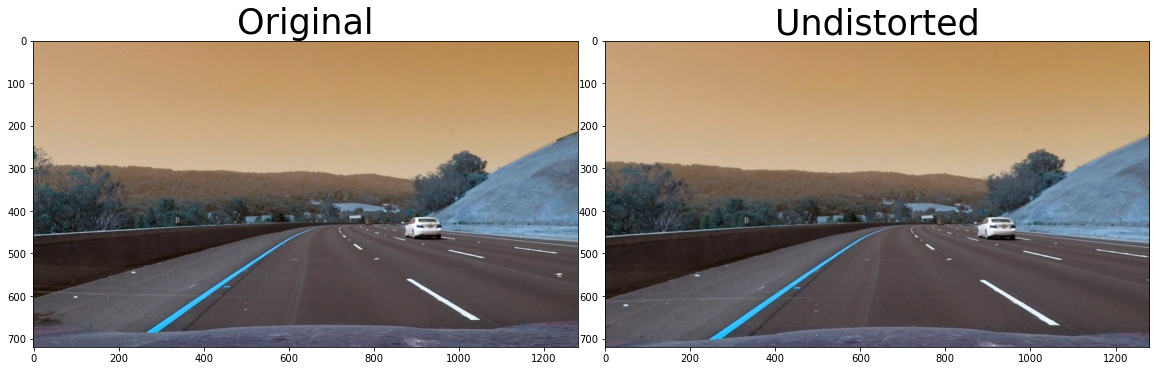

In [8]:
img = cv2.imread('./test_images/test3.jpg')

undist_img = undistort(img)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(img)
ax2.imshow(undist_img)
ax1.set_title('Original', fontsize=35)
ax2.set_title('Undistorted', fontsize=35)

In [9]:
def get_img_size(img):
    return (img.shape[1], img.shape[0])

In [10]:
# Perspective Transform

def warp(img):
    img_size = (img.shape[1], img.shape[0])
    src = np.float32([[690,450],[1110,img_size[1]],[175,img_size[1]],[595,450]])
    offset = 300
    dst = np.float32([[img_size[0]-offset, 0],[img_size[0]-offset, img_size[1]],
                      [offset, img_size[1]],[offset, 0]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return M, Minv, warped

Text(0.5, 1.0, 'Warped')

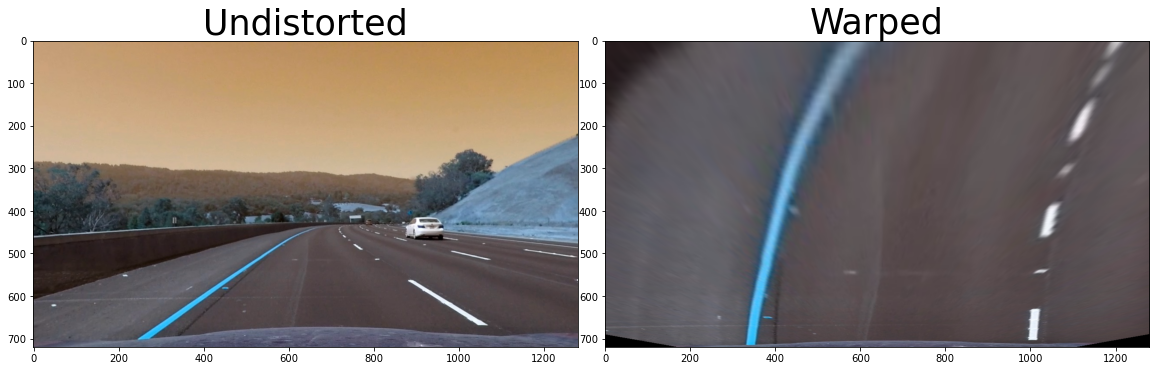

In [11]:
M, Minv, undist_img_warped = warp(undist_img)

# Visualize unwarp
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist_img)
ax1.set_title('Undistorted', fontsize=35)
ax2.imshow(undist_img_warped)
ax2.set_title('Warped', fontsize=35)

Text(0.5, 1.0, 'Blue Channel')

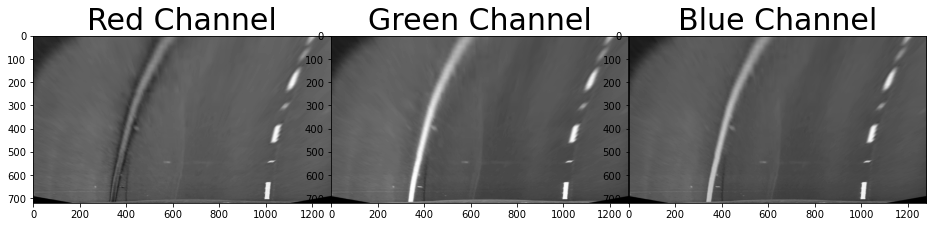

In [12]:
warped_R = undist_img_warped[:,:,0]
warped_G = undist_img_warped[:,:,1]
warped_B = undist_img_warped[:,:,2]


fig, axs = plt.subplots(1,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
axs[0].imshow(warped_R, cmap='gray')
axs[0].set_title('Red Channel', fontsize=30)
axs[1].imshow(warped_B, cmap='gray')
axs[1].set_title('Green Channel', fontsize=30)
axs[2].imshow(warped_G, cmap='gray')
axs[2].set_title('Blue Channel', fontsize=30)

Text(0.5, 1.0, 'Value Channel')

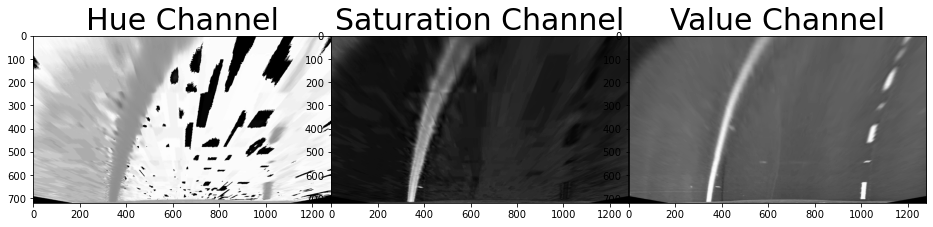

In [13]:
warped_HSV = cv2.cvtColor(undist_img_warped, cv2.COLOR_RGB2HSV)
warped_H = warped_HSV[:,:,0]
warped_S = warped_HSV[:,:,1]
warped_V = warped_HSV[:,:,2]

fig, axs = plt.subplots(1,3, figsize=(16, 12))
fig.subplots_adjust(hspace = .2, wspace=.001)
axs = axs.ravel()
axs[0].imshow(warped_H, cmap='gray')
axs[0].set_title('Hue Channel', fontsize=30)
axs[1].imshow(warped_S, cmap='gray')
axs[1].set_title('Saturation Channel', fontsize=30)
axs[2].imshow(warped_V, cmap='gray')
axs[2].set_title('Value Channel', fontsize=30)

In [14]:
def sobel_threshold(img, orient='x', thresh=(0, np.pi/2)):
    # 1. convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2. Sobel for x or y given the orient
    sobel = cv2.Sobel(gray, cv2.CV_64F, orient=='x', orient=='y')
    # 3) Take the absolute value of the derivative of the gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5. Create a binary mask
    binary = np.zeros_like(scaled_sobel)
    binary[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary

Text(0.5, 1.0, 'Sobel')

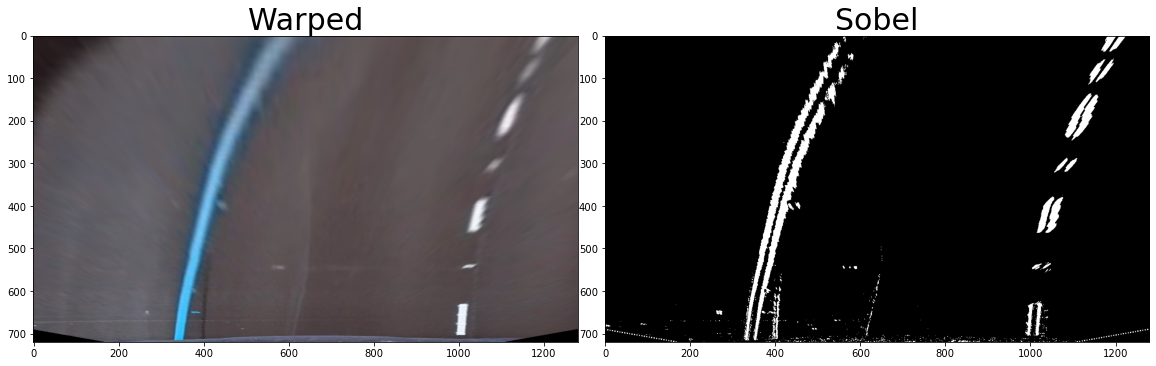

In [15]:
# Example

example_sobel = sobel_threshold(undist_img_warped, 'x', (11, 255))
# Visualize sobel absolute threshold
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(undist_img_warped)
ax1.set_title('Warped', fontsize=30)
ax2.imshow(example_sobel, cmap='gray')
ax2.set_title('Sobel', fontsize=30)

In [16]:
# The whole pipeline

def pipeline(img):
    img = cv2.imread(img)
    undist = undistort(img)
    M, Minv, warped = warp(undist)
    sobel = sobel_threshold(undist_img_warped, 'x', (11, 255))
    return sobel

Text(0.5, 1.0, 'Pipeline')

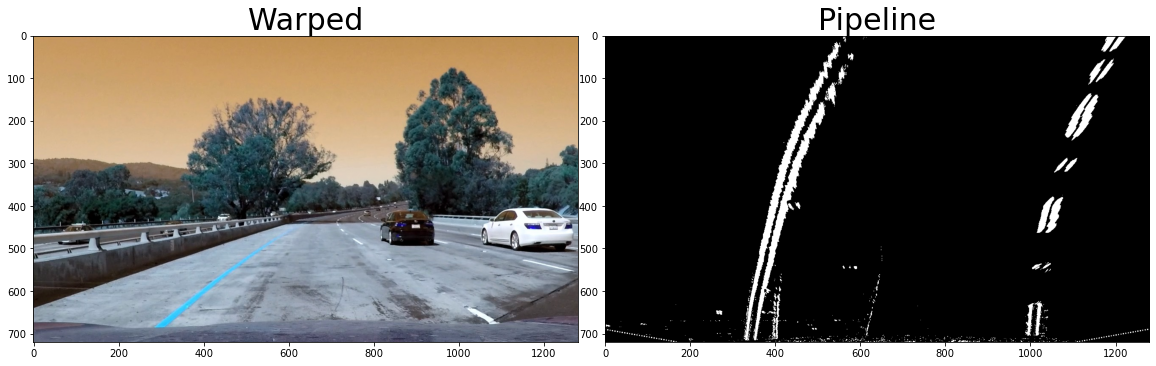

In [17]:
# Test the pipeline

test = glob.glob('./test_images/*.jpg')

example_sobel = pipeline(test[3])
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
f.subplots_adjust(hspace = .2, wspace=.05)
ax1.imshow(cv2.imread(test[3]))
ax1.set_title('Warped', fontsize=30)
ax2.imshow(example_sobel, cmap='gray')
ax2.set_title('Pipeline', fontsize=30)

In [18]:
def polyfit(img_shape, lefty, leftx, righty, rightx):
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    ploty = np.linspace(0, img_shape[0]-1, img_shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    return left_fitx, right_fitx, ploty

In [19]:
def sliding_window(img):
    histogram = np.sum(img[img.shape[0]//2:,:], axis=0)
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    out_img = np.dstack((img, img, img))
    
    nwindows = 8
    margin = 150
    minpix = 55
    
    window_height = np.int(img.shape[0]//nwindows)
    
    nzero = img.nonzero()
    nzeroy = np.array(nzero[0])
    nzerox = np.array(nzero[1])
    
    left_lane_inds = []
    right_lane_inds = []
    
    leftx_current = leftx_base
    rightx_current = rightx_base
    
    for window in range(nwindows):
        y_low = img.shape[0] - (window+1)*window_height
        y_high = img.shape[0] - window*window_height
        
        xleft_low = leftx_current - margin
        xleft_high = leftx_current + margin
        xright_low = rightx_current - margin
        xright_high = rightx_current + margin
        
        good_left_inds = ((nzeroy >= y_low) & (nzeroy < y_high) & 
        (nzerox >= xleft_low) &  (nzerox < xleft_high)).nonzero()[0]
        good_right_inds = ((nzeroy >= y_low) & (nzeroy < y_high) & 
        (nzerox >= xright_low) &  (nzerox < xright_high)).nonzero()[0]
        
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        cv2.rectangle(out_img,(xleft_low,y_low), (xleft_high,y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(xright_low, y_low), (xright_high, y_high),(0,255,0), 2) 
    
        if(len(good_left_inds) > minpix):
            leftx_current = np.int(np.mean(nzerox[good_left_inds]))
        if(len(good_right_inds) > minpix):
            rightx_current = np.int(np.mean(nzerox[good_right_inds]))
            
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    leftx = nzerox[left_lane_inds]
    lefty = nzeroy[left_lane_inds] 
    rightx = nzerox[right_lane_inds]
    righty = nzeroy[right_lane_inds]

    left_fitx, right_fitx, ploty = polyfit(out_img.shape, lefty, leftx, righty, rightx)

    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    # Plots the left and right polynomials on the lane lines
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
        
    return out_img, histogram, left_fitx, right_fitx

/Users/tiagovieira/opt/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tiagovieira/opt/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` o

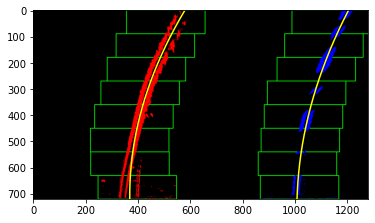

In [20]:
example = './test_images/test2.jpg'
example = pipeline(example)
    
img, hist, left_fitx, right_fitx = sliding_window(example)
plt.imshow(img)

(0.0, 1280.0)

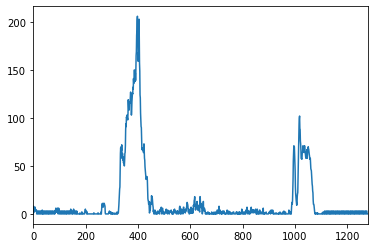

In [21]:
plt.plot(hist)
plt.xlim(0, 1280)

In [22]:
def polyfit_prev(img, left_fit, right_fit):
    margin = 100

    # Grab activated pixels
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    left_fitx, right_fitx, ploty = polyfit(img.shape, lefty, leftx, righty, rightx)
    
    out_img = np.dstack((img, img, img))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
    
    # Plot the polynomial lines onto the image
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    ## End visualization steps ##
    
    return result

/Users/tiagovieira/opt/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/tiagovieira/opt/anaconda3/envs/py3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` o

LinAlgError: SVD did not converge in Linear Least Squares

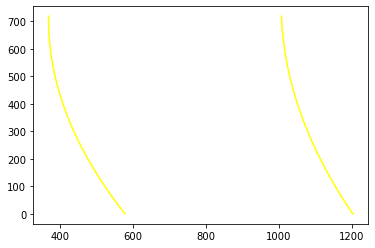

In [23]:
example = './test_images/test2.jpg'
example = pipeline(example)

img, hist, left_fit, right_fit = sliding_window(example)
result = polyfit_prev(example, left_fit, right_fit)

# View your output
plt.imshow(result)

In [ ]:
def calc_curvature:
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    